# MULTI-LAYER PERCEPTRON (MLP) CLASSIFIER

In [1]:
!pip install torch torchvision scikit-learn matplotlib tqdm

# Libraries import

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tqdm import tqdm
import random

In [3]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
            verbose (bool): If True, prints a message for each validation loss improvement.
            path (str): Path to save the best model.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f"Validation loss increased ({self.best_score:.6f} --> {val_loss:.6f})")
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.best_score:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.best_score = val_loss

# EXAMPLE: MNIST DATASET

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b1/MNIST_dataset_example.png/330px-MNIST_dataset_example.png)

# DATASET

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

## PREPROCESSING

Let's build the dataset, as in the previous example

In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading
train_dataset = datasets.MNIST(root='.', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='.', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


# SET THE CLASSIFIER

In [6]:
# Define MLP class
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout=0.0):
        super(MLP, self).__init__()
        layers = []
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            input_size = hidden_size
        hidden_size = input_size if num_layers == 1 else hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## TRAINING AND TESTING LOOPS

In [7]:
# Training function
def train(model, optimizer, criterion):
    model.train()
    for data, target in train_loader:
        data = data.view(data.size(0), -1).to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

# Evaluation function
def test(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.view(-1, 28*28).to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    return accuracy, all_preds, all_labels

### PLOT CONFUSION MATRIX

In [8]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:08<02:32,  8.02s/it]

Validation loss decreased (90.700000 --> -90.700000).  Saving model ...


 10%|█         | 2/20 [00:15<02:19,  7.75s/it]

Validation loss decreased (91.350000 --> -91.350000).  Saving model ...


 15%|█▌        | 3/20 [00:23<02:10,  7.70s/it]

Validation loss decreased (91.150000 --> -91.150000).  Saving model ...


 20%|██        | 4/20 [00:30<02:00,  7.55s/it]

Validation loss decreased (91.580000 --> -91.580000).  Saving model ...


 25%|██▌       | 5/20 [00:37<01:51,  7.45s/it]

Validation loss decreased (91.530000 --> -91.530000).  Saving model ...


 30%|███       | 6/20 [00:45<01:43,  7.39s/it]

Validation loss decreased (91.990000 --> -91.990000).  Saving model ...


 35%|███▌      | 7/20 [00:52<01:35,  7.35s/it]

Validation loss decreased (91.890000 --> -91.890000).  Saving model ...


 40%|████      | 8/20 [00:59<01:27,  7.33s/it]

Validation loss decreased (91.280000 --> -91.280000).  Saving model ...


 45%|████▌     | 9/20 [01:07<01:21,  7.39s/it]

Validation loss decreased (91.500000 --> -91.500000).  Saving model ...


 50%|█████     | 10/20 [01:14<01:13,  7.38s/it]

Validation loss decreased (91.740000 --> -91.740000).  Saving model ...


 55%|█████▌    | 11/20 [01:21<01:06,  7.39s/it]

Validation loss decreased (91.630000 --> -91.630000).  Saving model ...


 60%|██████    | 12/20 [01:29<00:58,  7.37s/it]

Validation loss decreased (92.250000 --> -92.250000).  Saving model ...


 65%|██████▌   | 13/20 [01:36<00:51,  7.42s/it]

Validation loss decreased (92.060000 --> -92.060000).  Saving model ...


 70%|███████   | 14/20 [01:44<00:44,  7.39s/it]

Validation loss decreased (91.900000 --> -91.900000).  Saving model ...


 75%|███████▌  | 15/20 [01:51<00:36,  7.37s/it]

Validation loss decreased (91.720000 --> -91.720000).  Saving model ...


 80%|████████  | 16/20 [01:59<00:29,  7.48s/it]

Validation loss decreased (91.960000 --> -91.960000).  Saving model ...


 85%|████████▌ | 17/20 [02:06<00:22,  7.50s/it]

Validation loss decreased (92.170000 --> -92.170000).  Saving model ...


 90%|█████████ | 18/20 [02:14<00:14,  7.47s/it]

Validation loss decreased (92.320000 --> -92.320000).  Saving model ...


 95%|█████████▌| 19/20 [02:21<00:07,  7.42s/it]

Validation loss decreased (92.050000 --> -92.050000).  Saving model ...


100%|██████████| 20/20 [02:28<00:00,  7.44s/it]

Validation loss decreased (91.330000 --> -91.330000).  Saving model ...


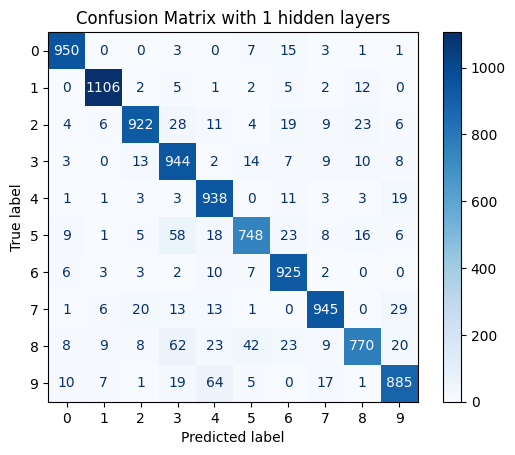

Layers: 1, Test Accuracy: 91.33%
MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


  5%|▌         | 1/20 [00:07<02:30,  7.92s/it]

Validation loss decreased (95.620000 --> -95.620000).  Saving model ...


 10%|█         | 2/20 [00:15<02:21,  7.89s/it]

Validation loss decreased (96.570000 --> -96.570000).  Saving model ...


 15%|█▌        | 3/20 [00:23<02:13,  7.87s/it]

Validation loss decreased (97.060000 --> -97.060000).  Saving model ...


 20%|██        | 4/20 [00:31<02:06,  7.94s/it]

Validation loss decreased (97.350000 --> -97.350000).  Saving model ...


 25%|██▌       | 5/20 [00:39<01:56,  7.78s/it]

Validation loss decreased (97.460000 --> -97.460000).  Saving model ...


 30%|███       | 6/20 [00:46<01:47,  7.69s/it]

Validation loss decreased (97.560000 --> -97.560000).  Saving model ...


 35%|███▌      | 7/20 [00:54<01:39,  7.64s/it]

Validation loss decreased (97.690000 --> -97.690000).  Saving model ...


 40%|████      | 8/20 [01:01<01:32,  7.67s/it]

Validation loss decreased (97.830000 --> -97.830000).  Saving model ...


 45%|████▌     | 9/20 [01:09<01:24,  7.67s/it]

Validation loss decreased (97.590000 --> -97.590000).  Saving model ...


 50%|█████     | 10/20 [01:17<01:16,  7.65s/it]

Validation loss decreased (97.740000 --> -97.740000).  Saving model ...


 55%|█████▌    | 11/20 [01:24<01:08,  7.61s/it]

Validation loss decreased (97.630000 --> -97.630000).  Saving model ...


 60%|██████    | 12/20 [01:32<01:01,  7.66s/it]

Validation loss decreased (97.980000 --> -97.980000).  Saving model ...


 65%|██████▌   | 13/20 [01:40<00:54,  7.76s/it]

Validation loss decreased (97.920000 --> -97.920000).  Saving model ...


 70%|███████   | 14/20 [01:48<00:47,  7.85s/it]

Validation loss decreased (97.820000 --> -97.820000).  Saving model ...


 75%|███████▌  | 15/20 [01:56<00:39,  7.89s/it]

Validation loss decreased (97.980000 --> -97.980000).  Saving model ...


 80%|████████  | 16/20 [02:04<00:31,  7.81s/it]

Validation loss decreased (97.930000 --> -97.930000).  Saving model ...


 85%|████████▌ | 17/20 [02:12<00:23,  7.92s/it]

Validation loss decreased (97.990000 --> -97.990000).  Saving model ...


 90%|█████████ | 18/20 [02:20<00:15,  7.94s/it]

Validation loss decreased (97.900000 --> -97.900000).  Saving model ...


 95%|█████████▌| 19/20 [02:28<00:07,  7.89s/it]

Validation loss decreased (97.840000 --> -97.840000).  Saving model ...


100%|██████████| 20/20 [02:35<00:00,  7.80s/it]

Validation loss decreased (97.990000 --> -97.990000).  Saving model ...


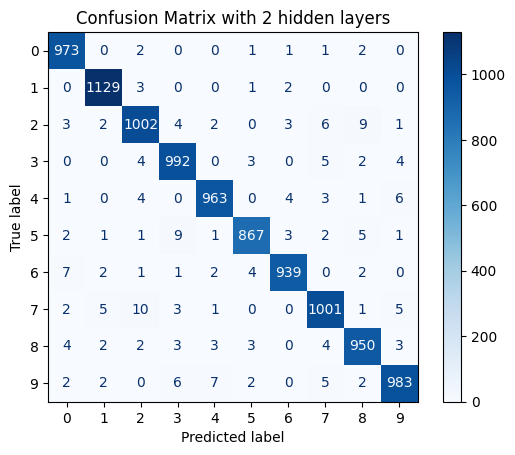

Layers: 2, Test Accuracy: 97.99%
MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)


  5%|▌         | 1/20 [00:08<02:36,  8.25s/it]

Validation loss decreased (96.330000 --> -96.330000).  Saving model ...


 10%|█         | 2/20 [00:16<02:30,  8.38s/it]

Validation loss decreased (97.210000 --> -97.210000).  Saving model ...


 15%|█▌        | 3/20 [00:24<02:20,  8.27s/it]

Validation loss decreased (97.380000 --> -97.380000).  Saving model ...


 20%|██        | 4/20 [00:32<02:10,  8.17s/it]

Validation loss decreased (97.450000 --> -97.450000).  Saving model ...


 25%|██▌       | 5/20 [00:41<02:02,  8.19s/it]

Validation loss decreased (97.850000 --> -97.850000).  Saving model ...


 30%|███       | 6/20 [00:49<01:54,  8.19s/it]

Validation loss decreased (97.980000 --> -97.980000).  Saving model ...


 35%|███▌      | 7/20 [00:57<01:48,  8.33s/it]

Validation loss decreased (97.910000 --> -97.910000).  Saving model ...


 40%|████      | 8/20 [01:06<01:40,  8.37s/it]

Validation loss decreased (97.910000 --> -97.910000).  Saving model ...


 45%|████▌     | 9/20 [01:14<01:31,  8.28s/it]

Validation loss decreased (98.080000 --> -98.080000).  Saving model ...


 50%|█████     | 10/20 [01:22<01:23,  8.31s/it]

Validation loss decreased (98.200000 --> -98.200000).  Saving model ...


 55%|█████▌    | 11/20 [01:31<01:14,  8.32s/it]

Validation loss decreased (98.060000 --> -98.060000).  Saving model ...


 60%|██████    | 12/20 [01:39<01:06,  8.34s/it]

Validation loss decreased (98.080000 --> -98.080000).  Saving model ...


 65%|██████▌   | 13/20 [01:47<00:57,  8.17s/it]

Validation loss decreased (98.250000 --> -98.250000).  Saving model ...


 70%|███████   | 14/20 [01:55<00:48,  8.05s/it]

Validation loss decreased (98.140000 --> -98.140000).  Saving model ...


 75%|███████▌  | 15/20 [02:02<00:39,  7.96s/it]

Validation loss decreased (98.210000 --> -98.210000).  Saving model ...


 80%|████████  | 16/20 [02:10<00:31,  7.90s/it]

Validation loss decreased (98.140000 --> -98.140000).  Saving model ...


 85%|████████▌ | 17/20 [02:18<00:23,  7.86s/it]

Validation loss decreased (98.060000 --> -98.060000).  Saving model ...


 90%|█████████ | 18/20 [02:26<00:15,  7.97s/it]

Validation loss decreased (98.260000 --> -98.260000).  Saving model ...


 95%|█████████▌| 19/20 [02:34<00:07,  7.99s/it]

Validation loss decreased (98.390000 --> -98.390000).  Saving model ...


100%|██████████| 20/20 [02:42<00:00,  8.12s/it]

Validation loss decreased (98.220000 --> -98.220000).  Saving model ...


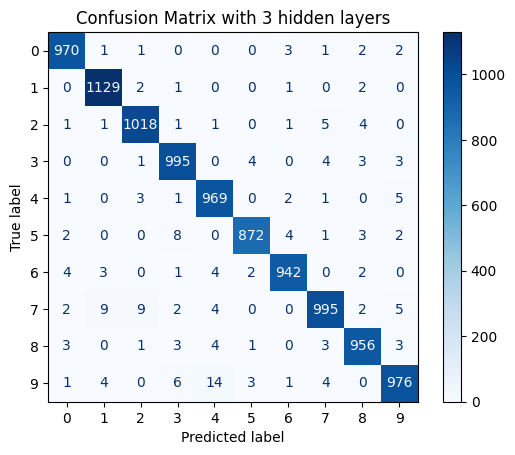

Layers: 3, Test Accuracy: 98.22%
MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=128, out_features=10, bias=True)
  )
)


  5%|▌         | 1/20 [00:08<02:34,  8.11s/it]

Validation loss decreased (95.760000 --> -95.760000).  Saving model ...


 10%|█         | 2/20 [00:16<02:24,  8.05s/it]

Validation loss decreased (97.000000 --> -97.000000).  Saving model ...


 15%|█▌        | 3/20 [00:24<02:17,  8.10s/it]

Validation loss decreased (97.290000 --> -97.290000).  Saving model ...


 20%|██        | 4/20 [00:32<02:09,  8.06s/it]

Validation loss decreased (97.430000 --> -97.430000).  Saving model ...


 25%|██▌       | 5/20 [00:41<02:04,  8.32s/it]

Validation loss decreased (97.600000 --> -97.600000).  Saving model ...


 30%|███       | 6/20 [00:49<01:57,  8.40s/it]

Validation loss decreased (97.970000 --> -97.970000).  Saving model ...


 35%|███▌      | 7/20 [00:58<01:49,  8.42s/it]

Validation loss decreased (97.920000 --> -97.920000).  Saving model ...


 40%|████      | 8/20 [01:06<01:39,  8.30s/it]

Validation loss decreased (97.880000 --> -97.880000).  Saving model ...


 45%|████▌     | 9/20 [01:14<01:32,  8.39s/it]

Validation loss decreased (97.930000 --> -97.930000).  Saving model ...


 50%|█████     | 10/20 [01:23<01:24,  8.47s/it]

Validation loss decreased (98.000000 --> -98.000000).  Saving model ...


 55%|█████▌    | 11/20 [01:31<01:16,  8.45s/it]

Validation loss decreased (98.160000 --> -98.160000).  Saving model ...


 60%|██████    | 12/20 [01:40<01:08,  8.52s/it]

Validation loss decreased (97.890000 --> -97.890000).  Saving model ...


 65%|██████▌   | 13/20 [01:48<00:58,  8.37s/it]

Validation loss decreased (98.120000 --> -98.120000).  Saving model ...


 70%|███████   | 14/20 [01:56<00:50,  8.34s/it]

Validation loss decreased (98.270000 --> -98.270000).  Saving model ...


 75%|███████▌  | 15/20 [02:04<00:41,  8.25s/it]

Validation loss decreased (98.140000 --> -98.140000).  Saving model ...


 80%|████████  | 16/20 [02:13<00:33,  8.26s/it]

Validation loss decreased (98.230000 --> -98.230000).  Saving model ...


 85%|████████▌ | 17/20 [02:21<00:24,  8.23s/it]

Validation loss decreased (98.090000 --> -98.090000).  Saving model ...


 90%|█████████ | 18/20 [02:29<00:16,  8.21s/it]

Validation loss decreased (98.080000 --> -98.080000).  Saving model ...


 95%|█████████▌| 19/20 [02:37<00:08,  8.29s/it]

Validation loss decreased (98.230000 --> -98.230000).  Saving model ...


100%|██████████| 20/20 [02:45<00:00,  8.30s/it]

Validation loss decreased (98.010000 --> -98.010000).  Saving model ...


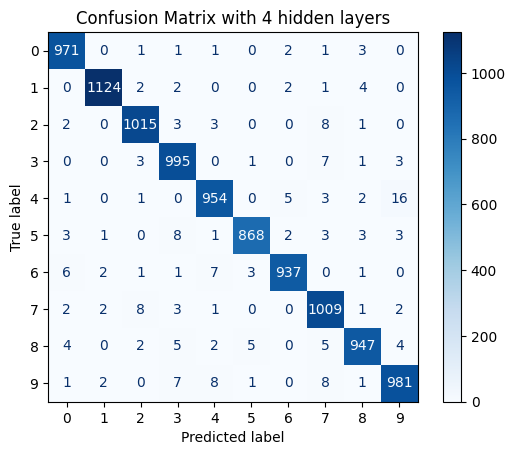

Layers: 4, Test Accuracy: 98.01%
MLP(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.25, inplace=False)
    (16): Linear(in_features=128, out_features=10, bias=True)
  )
)


  5%|▌         | 1/20 [00:08<02:44,  8.64s/it]

Validation loss decreased (96.430000 --> -96.430000).  Saving model ...


 10%|█         | 2/20 [00:17<02:35,  8.66s/it]

Validation loss decreased (96.630000 --> -96.630000).  Saving model ...


 15%|█▌        | 3/20 [00:25<02:26,  8.64s/it]

Validation loss decreased (97.350000 --> -97.350000).  Saving model ...


 20%|██        | 4/20 [00:35<02:20,  8.81s/it]

Validation loss decreased (97.580000 --> -97.580000).  Saving model ...


 25%|██▌       | 5/20 [00:43<02:12,  8.86s/it]

Validation loss decreased (97.610000 --> -97.610000).  Saving model ...


 30%|███       | 6/20 [00:52<02:04,  8.88s/it]

Validation loss decreased (97.830000 --> -97.830000).  Saving model ...


 35%|███▌      | 7/20 [01:01<01:55,  8.91s/it]

Validation loss decreased (97.770000 --> -97.770000).  Saving model ...


 40%|████      | 8/20 [01:10<01:45,  8.77s/it]

Validation loss decreased (97.910000 --> -97.910000).  Saving model ...


 45%|████▌     | 9/20 [01:19<01:37,  8.87s/it]

Validation loss decreased (97.770000 --> -97.770000).  Saving model ...


 50%|█████     | 10/20 [01:27<01:27,  8.77s/it]

Validation loss decreased (97.960000 --> -97.960000).  Saving model ...


 55%|█████▌    | 11/20 [01:36<01:19,  8.78s/it]

Validation loss decreased (98.130000 --> -98.130000).  Saving model ...


 60%|██████    | 12/20 [01:45<01:09,  8.70s/it]

Validation loss decreased (97.990000 --> -97.990000).  Saving model ...


 65%|██████▌   | 13/20 [01:53<00:59,  8.57s/it]

Validation loss decreased (98.170000 --> -98.170000).  Saving model ...


 70%|███████   | 14/20 [02:02<00:51,  8.54s/it]

Validation loss decreased (98.010000 --> -98.010000).  Saving model ...


 75%|███████▌  | 15/20 [02:10<00:42,  8.60s/it]

Validation loss decreased (98.210000 --> -98.210000).  Saving model ...


 80%|████████  | 16/20 [02:19<00:34,  8.52s/it]

Validation loss decreased (98.270000 --> -98.270000).  Saving model ...


 85%|████████▌ | 17/20 [02:27<00:25,  8.62s/it]

Validation loss decreased (98.330000 --> -98.330000).  Saving model ...


 90%|█████████ | 18/20 [02:36<00:17,  8.63s/it]

Validation loss decreased (98.240000 --> -98.240000).  Saving model ...


 95%|█████████▌| 19/20 [02:45<00:08,  8.63s/it]

Validation loss decreased (98.430000 --> -98.430000).  Saving model ...


100%|██████████| 20/20 [02:53<00:00,  8.68s/it]

Validation loss decreased (98.290000 --> -98.290000).  Saving model ...


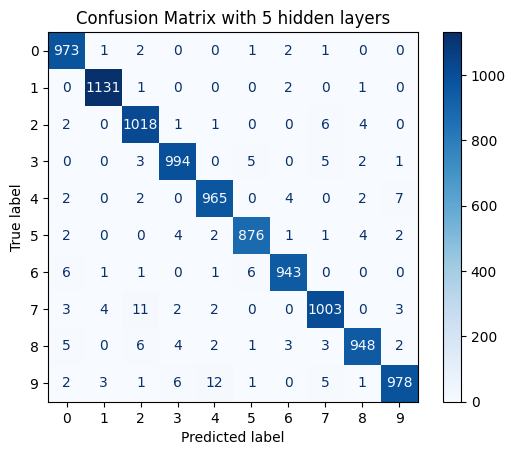

Layers: 5, Test Accuracy: 98.29%


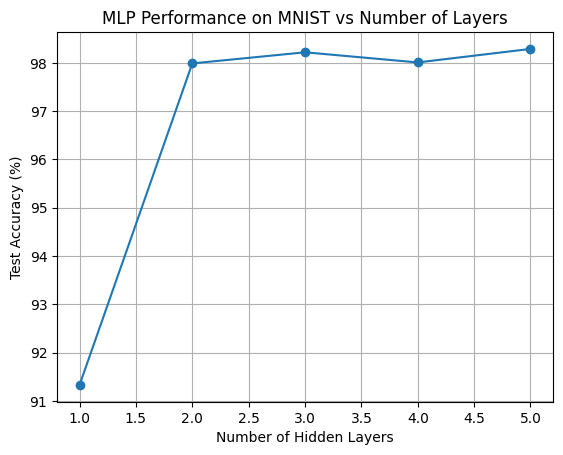

In [9]:
# Main comparison loop
accuracies = []
layer_range = range(1, 6)
num_epochs = 20

for num_layers in layer_range:
    model = MLP(28*28, 128, 10, num_layers, dropout=0.25).to(device)
    print(model)
    early_stopping = EarlyStopping(patience=3, verbose=True, path=f"model_{num_layers}_layers.pt")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in tqdm(range(num_epochs)): 
        train(model, optimizer, criterion)
        acc, _, _ = test(model, test_loader)
        early_stopping(val_loss=-acc, model=model)
        if early_stopping.early_stop:
            break

    model.load_state_dict(torch.load(f"model_{num_layers}_layers.pt"))
    acc, all_preds, all_labels = test(model, test_loader)
    plot_confusion_matrix(all_labels, all_preds, title=f"Confusion Matrix with {num_layers} hidden layers")
    print(f"Layers: {num_layers}, Test Accuracy: {acc:.2f}%")
    accuracies.append(acc)

# Plot results
plt.plot(layer_range, accuracies, marker='o')
plt.title('MLP Performance on MNIST vs Number of Layers')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.show()


# TESTING THE MODEL

In [23]:
test_id = random.randint(0, len(test_dataset))
print(f"Testing val data point n.{test_id}")

Testing val data point n.5094


In [24]:
features, gt = test_dataset[test_id]
features.size()

torch.Size([1, 28, 28])

PLotting the testing image 

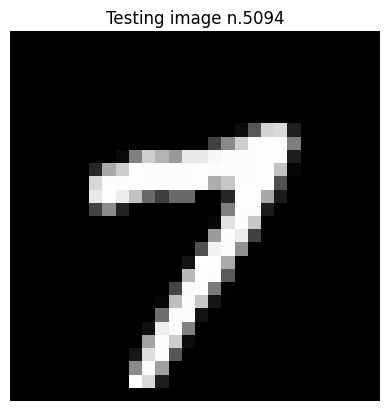

In [25]:
image = features.squeeze()
plt.imshow(image, cmap="grey")
plt.title(f"Testing image n.{test_id}")
plt.axis("off")
plt.show()

In [26]:
print(f"The image showcases the number {gt}")

The image showcases the number 7


In [27]:
features.flatten().unsqueeze(dim=0).size()

torch.Size([1, 784])

In [28]:
with torch.no_grad():
    for num_layers in layer_range:
        model = model = MLP(28*28, 128, 10, num_layers, dropout=0.25).to(device)
        model.load_state_dict(torch.load(f"model_{num_layers}_layers.pt"))
        model.eval()
        test_point = features.flatten().unsqueeze(dim=0).to(device)
        print(test_point.size())
        output = model(test_point)
        reg_out = nn.Softmax(dim=-1)(output).cpu().squeeze().tolist()
        out_class = output.argmax().cpu().item()
        print(f"The image has been classified as a {out_class} with probability of {reg_out[out_class]:.2f}%")

torch.Size([1, 784])
The image has been classified as a 7 with probability of 0.99%
torch.Size([1, 784])
The image has been classified as a 7 with probability of 1.00%
torch.Size([1, 784])
The image has been classified as a 7 with probability of 1.00%
torch.Size([1, 784])
The image has been classified as a 7 with probability of 1.00%
torch.Size([1, 784])
The image has been classified as a 7 with probability of 1.00%
